The code is adapted from the excellent [GPT tutorial](https://keras.io/examples/generative/text_generation_with_miniature_gpt/) created by Apoorv Nandan available on the Keras website.



#### Attention
An attention mechanism (also know as an attention head) in a Transformer is designed to
do exactly this. It is able to decide where in the input it wants to pull information from, in
order to efficiently extract useful information without being clouded by irrelevant details.
This makes it highly adaptable to a range of circumstances, as it can decide where it
wants to look for information at inference time

In contrast, a recurrent layer tries to build up a generic hidden state that captures an
overall representation of the input at each timestep. A weakness of this approach is that
many of the words that have already been incorporated into the hidden vector will not be
directly relevant to the immediate task at hand (e.g., predicting the next word), as we
have just seen. Attention heads do not suffer from this problem, because they can pick
and choose how to combine information from nearby words, depending on the context

#### Queries, Keys, and Values
So how does an attention head decide where it wants to look for information? Before we
get into the details, let’s explore how it works at a high level, using our pink elephant
example.

Imagine that we want to predict what follows the word too. To help with this task, other
preceding words chime in with their opinions, but their contributions are weighted by how
confident they are in their own expertise in predicting words that follow too. For example,
the word elephant might confidently contribute that it is more likely to be a word related
to size or loudness, whereas the word was doesn’t have much to offer to narrow down the
possibilities.

In other words, we can think of an attention head as a kind of information retrieval
system, where a query (“What word follows too?”) is made into a key/value store (other
words in the sentence) and the resulting output is a sum of the values, weighted by the
resonance between the query and each key.

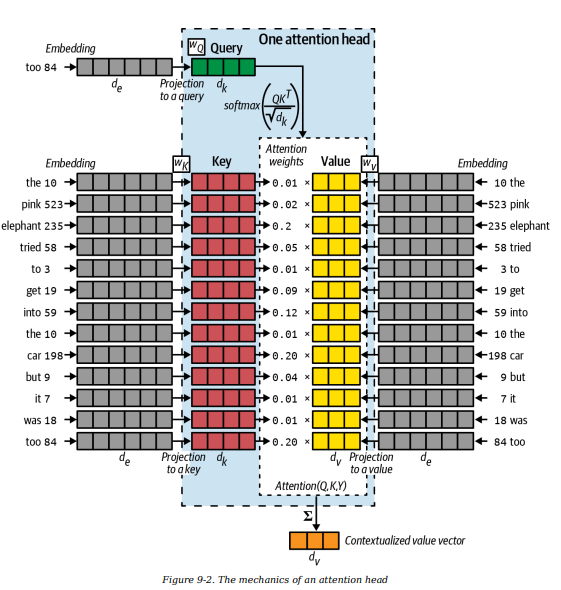



- The query (Q) can be thought of as a representation of the current task at hand (e.g.,
“What word follows too?”). In this example, it is derived from the embedding of the word
too, by passing it through a weights matrix WQ to change the dimensionality of the vector
from de to dk.

- The key vectors (K) are representations of each word in the sentence—you can think of
these as descriptions of the kinds of prediction tasks that each word can help with. They
are derived in a similar fashion to the query, by passing each embedding through a
weights matrix WK to change the dimensionality of each vector from de to dk. Notice that
the keys and the query are the same length (dk).

- Inside the attention head, each key is compared to the query using a dot product between
each pair of vectors (QKT). This is why the keys and the query have to be the same
length. The higher this number is for a particular key/query pair, the more the key
resonates with the query, so it is allowed to make more of a contribution to the output of
the attention head. The resulting vector is scaled by √dk to keep the variance of the
vector sum stable (approximately equal to 1), and a softmax is applied to ensure the
contributions sum to 1. This is a vector of attention weights.

- The value vectors (V ) are also representations of the words in the sentence—you can
think of these as the unweighted contributions of each word. They are derived by passing
each embedding through a weights matrix WV to change the dimensionality of each vector
from de to dv. Notice that the value vectors do not necessarily have to have the same
length as the keys and query (but often do, for simplicity).

- The value vectors are multiplied by the attention weights to give the attention for a given
Q, K, and V , as shown in

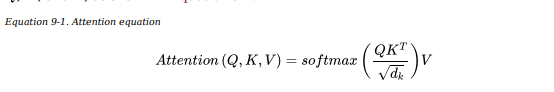



#### Multihead Attention
There’s no reason to stop at just one attention head! In Keras, we can build a
MultiHeadAttention layer that concatenates the output from multiple attention heads,
allowing each to learn a distinct attention mechanism so that the layer as a whole can
learn more complex relationships.

The concatenated outputs are passed through one final weights matrix WO to project the
vector into the desired output dimension, which in our case is the same as the input
dimension of the query (de), so that the layers can be stacked sequentially on top of each
other.




#### Causal Masking
So far, we have assumed that the query input to our attention head is a single vector. However, for efficiency during training, we would ideally like the attention layer to be
able to operate on every word in the input at once, predicting for each what the
subsequent word will be. In other words, we want our GPT model to be able to handle a
group of query vectors in parallel (i.e., a matrix).
You might think that we can just batch the vectors together into a matrix and let linear
algebra handle the rest. This is true, but we need one extra step—we need to apply a
mask to the query/key dot product, to avoid information from future words leaking
through. This is known as causal masking and is shown in 

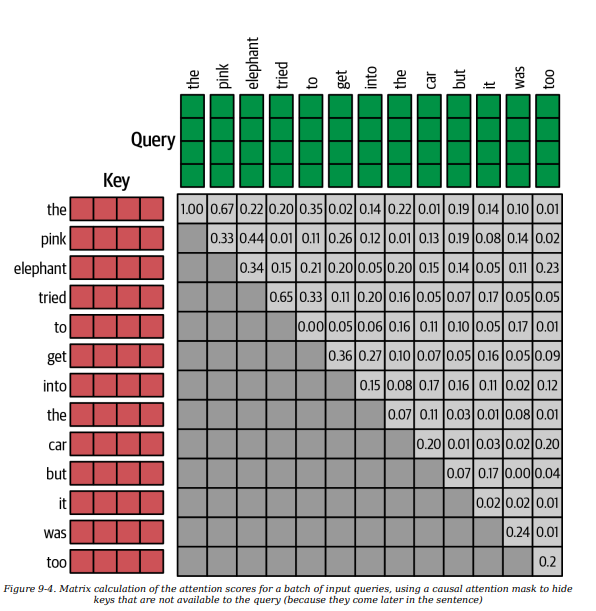

Without this mask, our GPT model would be able to perfectly guess the next word in the
sentence, because it would be using the key from the word itself as a feature! The code
for creating a causal mask is shown in Example 9-3, and the resulting numpy array
(transposed to match the diagram)

#### The Transformer Block
A Transformer block is a single component within a Transformer that applies some skip
connections, feed-forward (dense) layers, and normalization around the multihead
attention layer. A diagram of a Transformer block is shown in

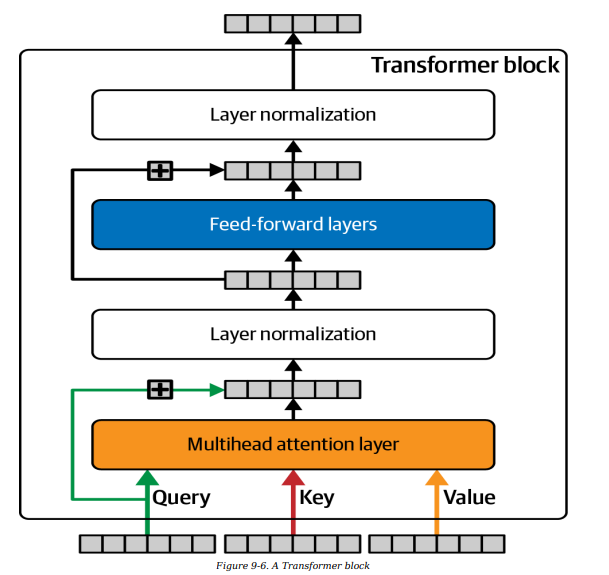

- Firstly, notice how the query is passed around the multihead attention layer to be added
to the output—this is a skip connection and is common in modern deep learning
architectures. It means we can build very deep neural networks that do not suffer as
much from the vanishing gradient problem, because the skip connection provides a
gradient-free highway that allows the network to transfer information forward
uninterrupted.

- Secondly, layer normalization is used in the Transformer block to provide stability to the
training process. We have already seen the batch normalization layer in action throughout
this book, where the output from each channel is normalized to have a mean of 0 and
standard deviation of 1. The normalization statistics are calculated across the batch and
spatial dimensions.

- In contrast, layer normalization in a Transformer block normalizes each position of each
sequence in the batch by calculating the normalizing statistics across the channels. It is
the complete opposite of batch normalization, in terms of how the normalization statistics
are calculated. A diagram showing the difference between batch normalization and layer
normalization is shown in

In [12]:
from tensorflow.keras import layers, models, callbacks, optimizers, losses,metrics, utils
import tensorflow as tf
import numpy as np
import json, re,string

#### 0. Parameters

In [3]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 5

In [7]:
with open("C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\wine\\winemag-data-130k-v2.json") as json_data:
    wine_data = json.load(json_data)


In [8]:
wine_data[:10]

[{'points': '87',
  'title': 'Nicosia 2013 Vulkà Bianco  (Etna)',
  'description': "Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",
  'taster_name': 'Kerin O’Keefe',
  'taster_twitter_handle': '@kerinokeefe',
  'price': None,
  'designation': 'Vulkà Bianco',
  'variety': 'White Blend',
  'region_1': 'Etna',
  'region_2': None,
  'province': 'Sicily & Sardinia',
  'country': 'Italy',
  'winery': 'Nicosia'},
 {'points': '87',
  'title': 'Quinta dos Avidagos 2011 Avidagos Red (Douro)',
  'description': "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.",
  'taster_name': 'Roger Voss',
  'taster_twitter_handle': '@vossroger',
  'price': 15,
  'designation': 'Avidagos',
  'variety': 'Portugu

In [9]:
filtered_data = ["wine review : " + x['country'] 
                 + ' : ' 
                 + x['province'] 
                 + ' : '
                 + x['variety']
                 + ' : '
                 + x['description']
                 for x in wine_data
                 if x['country'] is not None 
                 and x['province'] is not None
                 and x['variety'] is not None
                 and x['description'] is not None]

In [10]:
n_wines = len(filtered_data)
print(f"{n_wines} recipes loaded")

129907 recipes loaded


#### 2. Tokenize Data

In [14]:
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation},'\n'])",r" \1 ",s)
    s = re.sub(" +"," ",s)
    return s

text_data = [pad_punctuation(x) for x in filtered_data]

In [15]:
example_data = text_data[25]
example_data

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard - designated Pinot that hails from a high - elevation site . Small in production , it offers intense , full - bodied raspberry and blackberry steeped in smoky spice and smooth texture . '